# Image Classification using AWS Sagemaker

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [1]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
!pip install bokeh==2.4.3

  Using cached smdebug-1.0.34-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached protobuf-3.20.3-cp310-cp310-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (1.1 MB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp310-cp310-linux_x86_64.whl
Using cached smdebug-1.0.34-py2.py3-none-any.whl (280 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.21.12
    Uninstalling protobuf-4.21.12:
      Successfully uninstalled protobuf-4.21.12
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sagemaker 2.198.0 requires boto3<2.0,>=1.29.6, but you have boto3 1.28.64 which is incompatible.
  Using cached bokeh-2.4.3-py3-none-any.whl (18.5 MB)


In [67]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

import boto3

from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
import sagemaker
from sagemaker.pytorch import PyTorch

import smdebug.pytorch as smd
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

import os
import IPython

from PIL import Image
import io
import requests

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [3]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip --no-check-certificate
!unzip dogImages.zip

--2024-02-06 04:01:28--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.220.248, 52.219.216.16, 52.219.220.136, ...
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.220.248|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  47.3MB/s    in 26s     

2024-02-06 04:01:54 (41.9 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogI

In [4]:
sagemaker_session = sagemaker.Session()

bucket = sagemaker_session.default_bucket()
prefix = "sagemaker/Image-Classification-using-AWS-Sagemaker/dogImages"

role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [5]:
%%time
inputs = sagemaker_session.upload_data(path="./dogImages", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

input spec (in this case, just an S3 path): s3://sagemaker-us-east-1-002137745123/sagemaker/Image-Classification-using-AWS-Sagemaker/dogImages
CPU times: user 52.7 s, sys: 7.36 s, total: 1min
Wall time: 13min 7s


In [6]:
os.environ['SM_CHANNEL_TRAIN'] = "s3://{}/{}/".format(bucket, prefix)
os.environ['SM_MODEL_DIR'] = "s3://{}/{}/{}/".format(bucket, prefix, "output")

In [7]:
os.environ['SM_CHANNEL_TRAIN'], os.environ['SM_MODEL_DIR']

('s3://sagemaker-us-east-1-002137745123/sagemaker/Image-Classification-using-AWS-Sagemaker/dogImages/',
 's3://sagemaker-us-east-1-002137745123/sagemaker/Image-Classification-using-AWS-Sagemaker/dogImages/output/')

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [8]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256, 512]),
    "epochs": IntegerParameter(2, 4)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [9]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="scripts/hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)# TODO: Your estimator here

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)# TODO: Your HP tuner here

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [10]:
# TODO: Fit your HP Tuner
tuner.fit({"training": inputs}, wait=True) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


Using provided s3_resource
.............................................................................................................................................................................................................................!


In [11]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2024-02-06 04:27:51 Starting - Preparing the instances for training
2024-02-06 04:27:51 Downloading - Downloading the training image
2024-02-06 04:27:51 Training - Training image download completed. Training in progress.
2024-02-06 04:27:51 Uploading - Uploading generated training model
2024-02-06 04:27:51 Completed - Resource reused by training job: pytorch-training-240206-0415-003-181a65a8


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"512"',
 'epochs': '3',
 'lr': '0.008948089012940693',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2024-02-06-04-15-19-193"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-002137745123/pytorch-training-2024-02-06-04-15-19-193/source/sourcedir.tar.gz"'}

In [12]:
hyperparameters = {"batch-size": int(best_estimator.hyperparameters()['batch-size'].replace('"', '')),
                   "epochs": int(best_estimator.hyperparameters()['epochs'].replace('"', '')),
                   "lr": best_estimator.hyperparameters()['lr']
                  }
hyperparameters

{'batch-size': 512, 'epochs': 3, 'lr': '0.008948089012940693'}

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [127]:
# TODO: Set up debugging and profiling rules and hooks
rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [128]:
# TODO: Create and fit an estimator

estimator = PyTorch(
    entry_point="scripts/train_model.py",
    role=role,
    py_version="py36",
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)# TODO: Your estimator here

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [129]:
# TODO: Plot a debugging output.
estimator.fit({"training": inputs}, wait=True)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.


Using provided s3_resource


INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: latest.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc

2024-02-06 09:27:19 Starting - Starting the training job
2024-02-06 09:27:19 Pending - Training job waiting for capacity...LossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2024-02-06 09:28:11 Pending - Preparing the instances for training......
2024-02-06 09:29:11 Downloading - Downloading input data......
2024-02-06 09:30:13 Downloading - Downloading the training image.....................
2024-02-06 09:33:52 Training - Training image download completed. Training in progress...bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-02-06 09:33:57,736 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-02-06 09:33:57,766 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-02-06 09:33:57,768

In [130]:
session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2024-02-06-09-27-17-855
Region: us-east-1


In [131]:
trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2024-02-06 09:44:44.101 default:110 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-002137745123/pytorch-training-2024-02-06-09-27-17-855/debug-output
[2024-02-06 09:44:44.459 default:110 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-02-06 09:44:45.484 default:110 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer4.0.relu_input_0', 'layer4.0.relu_input_1', 'layer4.1.relu_input_0', 'layer4.1.relu_input_1', 'relu_input_0']
1
1


In [132]:
tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-002137745123/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}, 'DisableProfiler': False}
s3 path:s3://sagemaker-us-east-1-002137745123/pytorch-training-2024-02-06-09-27-17-855/profiler-output


Profiler data from system is available


In [133]:
system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2024-02-06 09:44:45.705 default:110 INFO metrics_reader_base.py:134] Getting 15 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


In [134]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-002137745123/pytorch-training-2024-02-06-09-27-17-855/rule-output


In [135]:
! aws s3 ls {rule_output_path} --recursive

2024-02-06 09:44:04     425161 pytorch-training-2024-02-06-09-27-17-855/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-02-06 09:44:04     282936 pytorch-training-2024-02-06-09-27-17-855/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-02-06 09:43:59        539 pytorch-training-2024-02-06-09-27-17-855/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-02-06 09:43:59      27454 pytorch-training-2024-02-06-09-27-17-855/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-02-06 09:43:59       2153 pytorch-training-2024-02-06-09-27-17-855/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-02-06 09:43:59        310 pytorch-training-2024-02-06-09-27-17-855/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-02-06 09:43:59       2131 pytorch-training-2024-02-06-09-27-17-855/rule-output/ProfilerReport/profiler-output/profiler-re

In [136]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-002137745123/pytorch-training-2024-02-06-09-27-17-855/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-002137745123/pytorch-training-2024-02-06-09-27-17-855/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-002137745123/pytorch-training-2024-02-06-09-27-17-855/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-002137745123/pytorch-training-2024-02-06-09-27-17-855/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-002137745123/pytorch-training-2024-02-06-09-27-17-855/rule-output/Profi

In [137]:
# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

## PoorWeightInitialization: Error

The error message **PoorWeightInitialization** suggests that there may be an issue with the initialization of weights in a neural network during training. Weight initialization is a crucial step in training neural networks, and improper initialization can lead to difficulties in convergence or slow learning.

### Common Reasons and Solutions:

1. **Improper Initialization:**
   - *Solution:* Ensure that the weights of your neural network are initialized appropriately. Common methods include Gaussian initialization (`torch.nn.init.normal_` in PyTorch) or Xavier/Glorot initialization (`torch.nn.init.xavier_normal_` or `torch.nn.init.xavier_uniform_`).

2. **Vanishing/Exploding Gradients:**
   - *Solution:* Adjust the scale of initialization based on the network architecture and activation functions.

3. **Activation Function Compatibility:**
   - *Solution:* Match the weight initialization method with the activation functions used in your network.

4. **Check Your Code:**
   - *Solution:* Ensure there are no bugs or typos in your code related to weight initialization. Double-check the layers where the error is occurring.

5. **Gradient Clipping:**
   - *Solution:* Apply gradient clipping using techniques like `torch.nn.utils.clip_grad_norm_` in PyTorch if exploding gradients are an issue.

6. **Learning Rate:**
   - *Solution:* Experiment with different learning rates to find a suitable value for your specific model and dataset.

7. **Debugging with Smaller Networks:**
   - Test your model with a smaller network to identify if the issue is related to the architecture or the initialization process.

Remember to analyze the specific details of your neural network architecture, activation functions, and the context in which the error is occurring. Adjusting the initialization method and experimenting with hyperparameters can often resolve the "PoorWeightInitialization" issue.


In [138]:
# TODO: Display the profiler output
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [139]:
?PyTorchModel

Init signature:
PyTorchModel(
    model_data: Union[str, sagemaker.workflow.entities.PipelineVariable],
    role: Optional[str] = None,
    entry_point: Optional[str] = None,
    framework_version: str = '1.3',
    py_version: Optional[str] = None,
    image_uri: Union[str, sagemaker.workflow.entities.PipelineVariable, NoneType] = None,
    predictor_cls: <built-in function callable> = <class 'sagemaker.pytorch.model.PyTorchPredictor'>,
    model_server_workers: Union[int, sagemaker.workflow.entities.PipelineVariable, NoneType] = None,
    **kwargs,
)
Docstring:      An PyTorch SageMaker ``Model`` that can be deployed to a SageMaker ``Endpoint``.
Init docstring:
Initialize a PyTorchModel.

Args:
    model_data (str or PipelineVariable): The S3 location of a SageMaker model data
        ``.tar.gz`` file.
    role (str): An AWS IAM role (either name or full ARN). The Amazon
        SageMaker training jobs and APIs that create Amazon SageMaker
        endpoints use this role to access tra

In [140]:
# TODO: Deploy your model to an endpoint

# predictor = estimator.deploy(initial_instance_count=1, instance_type="ml.g4dn.xlarge") # TODO: Add your deployment configuration like instance type and number of instances

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

pytorch_model = PyTorchModel(
    model_data='s3://{}/{}/output/model.tar.gz'.format(bucket, estimator.latest_training_job.name), 
    role=role, 
    entry_point='scripts/inference.py',
    py_version="py36",
    framework_version="1.8",
    predictor_cls=ImagePredictor
)

predictor = pytorch_model.deploy(initial_instance_count=1, instance_type="ml.g4dn.xlarge")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-002137745123/pytorch-training-2024-02-06-09-27-17-855/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-002137745123/pytorch-inference-2024-02-06-09-44-50-708/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-02-06-09-44-55-959
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-02-06-09-44-56-763
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-02-06-09-44-56-763


---------!

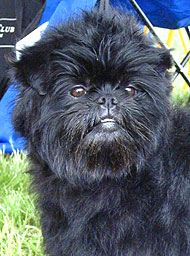

In [141]:
# TODO: Run an prediction on the endpoint

payload = None
with open("./dogImages/valid/001.Affenpinscher/Affenpinscher_00041.jpg", 'rb') as f:
    payload = f.read()# TODO: Your code to load and preprocess image to send to endpoint for prediction

Image.open(io.BytesIO(payload))

In [142]:
img = Image.open(io.BytesIO(payload))

In [143]:
img.format, img.size

('JPEG', (190, 256))

In [144]:
response = predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2024-02-06-09-44-56-763 in account 002137745123 for more information.

In [ ]:
pred = np.argmax(response, 1)+1
print(f"Actual: {int(image_path[17:20])}, Prediction: {pred[0]}")

In [ ]:
print(payload)

In [36]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

image = Image.open("./dogImages/valid/001.Affenpinscher/Affenpinscher_00038.jpg")

transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

preprocessed_image = transform(image).unsqueeze(0)
preprocessed_image = preprocessed_image.to("cpu")

response = predictor.predict(preprocessed_image)
pred = np.argmax(response, 1)+1
plt.imshow(Image.open(image_path))
plt.show()
print(f"Actual: {int(image_path[17:20])}, Prediction: {pred[0]}")


ParamValidationError: Parameter validation failed:
Invalid type for parameter Body, value: tensor([[[[0.3490, 0.3490, 0.3451,  ..., 0.3255, 0.2549, 0.1961],
          [0.3569, 0.3529, 0.3490,  ..., 0.3255, 0.2510, 0.1961],
          [0.3608, 0.3569, 0.3569,  ..., 0.3137, 0.2353, 0.1882],
          ...,
          [0.4627, 0.4706, 0.4471,  ..., 0.3961, 0.3686, 0.3098],
          [0.4431, 0.4353, 0.4078,  ..., 0.3765, 0.3373, 0.3373],
          [0.4471, 0.4431, 0.3490,  ..., 0.4392, 0.4118, 0.4431]],

         [[0.3882, 0.3882, 0.3882,  ..., 0.4000, 0.3255, 0.2667],
          [0.3961, 0.3922, 0.3922,  ..., 0.4000, 0.3216, 0.2667],
          [0.4000, 0.3961, 0.4000,  ..., 0.3882, 0.3059, 0.2588],
          ...,
          [0.5608, 0.5765, 0.5686,  ..., 0.4980, 0.4627, 0.4000],
          [0.5020, 0.5098, 0.5059,  ..., 0.4431, 0.4078, 0.4118],
          [0.4863, 0.4980, 0.4275,  ..., 0.4824, 0.4667, 0.5020]],

         [[0.2941, 0.2824, 0.2745,  ..., 0.3255, 0.2627, 0.2039],
          [0.2980, 0.2902, 0.2784,  ..., 0.3255, 0.2588, 0.2039],
          [0.3020, 0.2941, 0.2824,  ..., 0.3176, 0.2431, 0.1961],
          ...,
          [0.2902, 0.3059, 0.2863,  ..., 0.3137, 0.2667, 0.1961],
          [0.2471, 0.2510, 0.2314,  ..., 0.2706, 0.2196, 0.2118],
          [0.2392, 0.2431, 0.1569,  ..., 0.3176, 0.2824, 0.3059]]]]), type: <class 'torch.Tensor'>, valid types: <class 'bytes'>, <class 'bytearray'>, file-like object

In [ ]:
print(response)

In [119]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2024-02-06-08-48-51-330
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2024-02-06-08-48-51-330


In [ ]:
tuner.delete_endpoint()